In [2]:
import cv2
import sqlite3
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import open3d
import seaborn as sns
import random
import sys
import math
import plotly.graph_objects as go
from visualize_model import Model
from database import blob_to_array, pair_id_to_image_ids
import plotly.graph_objects as goimport utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. 3D mesh reconstruction from a set of images from the Gerrard Hall dataset.

This exercise was used as an initial exploration of COLMAP in order to become familiar with its workflow, reconstruction pipeline, and the different representations it produces.

First, we installed Colmap and runned the automatic reconstruction on the Gerrard Hall dataset. This pipeline consists of two main stages: **sparse reconstruction** and **dense reconstruction**.

## Sparse reconstruction

After running the automatic reconstruction, we visualized the *sparse* reconstruction directly in COLMAP. This visualization shows the recovered camera poses (in red) and the 3D sparse point cloud representing the structure of the scene. As shown in **Figure 1**, this sparse model allows us to verify that the cameras have been correctly localized and that the general geometry of the scene has been recovered.

<p align="center">
  <img src="figures/gerrard_hall_colmap.png" width="45%">
</p>
<p align="center"><b>Figure 1:</b> Sparse reconstruction visualized in COLMAP, showing the estimated camera poses (red) and the sparse 3D point cloud.</p>

## Dense reconstruction

Once the sparse reconstruction was completed, COLMAP computed a *dense* reconstruction, which produces a much denser point cloud and allows generating a surface mesh.

For the meshing step, different reconstruction methods can be used, such as:

* **Poisson Meshing**: Produces smooth and detailed surfaces, preserving fine geometric details and color information. However, it may introduce holes or missing regions in areas with insufficient data.

* **Delaunay Meshing**: Produces a more complete surface and tends to close gaps, but usually lacks fine details and does not preserve color information as well as Poisson.

A visual comparison between the two meshing strategies is shown in **Figure 2**. In our case, we chose the **Poisson** mesher for the reconstruction, as it provided better visual quality, finer details, and more accurate color information.


<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_poisson.png" width="85%">
    <p><b>(a)</b> Poisson mesh reconstruction.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_delaunay.png" width="85%">
    <p><b>(b)</b> Delaunay mesh reconstruction.</p>
  </div>
</div>

<p align="center"><b>Figure 2:</b> Comparison between Poisson and Delaunay meshing. The Poisson mesh preserves fine geometric details and color information, while the Delaunay mesh produces a more complete but less detailed surface.</p>

After selecting the Poisson mesher, COLMAP produced two different mesh representations: 

* `meshed-poisson.ply`: A smooth surface mesh obtained via Poisson reconstruction. It preserves fine details and color but may contain holes or artifacts.

* `fused.ply`: A fused point-based surface representation, which is less smooth but more directly connected to the original dense point cloud.

A visual comparison between both representations is shown in **Figure 3**. 

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_poisson.png" style="width: 85%;">
    <p><b>(a)</b> <code>meshed-poisson.ply</code></p>
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_poisson_fused.png" style="width: 85%;">
    <p><b>(b)</b> <code>fused.ply</code></p>
  </div>
</div>

<p align="center"><b>Figure 3:</b> Comparison between the two mesh representations generated by COLMAP. The Poisson mesh (a) produces a smoother and more visually detailed surface, while the fused representation (b) is noisier but more directly connected to the original dense point cloud.</p>

Based on this comparison, we selected the `meshed-poisson.ply` representation as our "final" mesh, as it provides smoother surfaces, better geometric details, and more accurate color information. Although it may contain some small holes or artifacts, these can be corrected through post-processing. 

## Mesh Post-processing

As we can see in **Figure 4**, the raw mesh contained several artifacts and noisy components, especially around the borders and less constrained regions.

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_before_1.png" style="width: 85%;">
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_before_2.png" style="width: 85%;">
  </div>
</div>
<p align="center"><b>Figure 4:</b> Two different views of the raw <code>meshed-poisson.ply</code> mesh, showing artifacts and noisy regions, especially near the borders.</p>


To improve the final result, we applied different cleaning filters in MeshLab, such as:

*  **Removing isolated components (wrt Diameter)**, 
* **Manually removed a connected region** that corresponded to a reconstruction artifact by selecting the undesired faces with a rectangular selection tool and deleting the selected vertices and faces. 

**Figure 5** hows the cleaned versions of the previous meshes, obtained after applying the post-processing steps described above.

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_after_1.png" style="width: 85%;">
  </div>
  <div style="text-align: center;">
    <img src="figures/gerrard_hall_mesh_after_2.png" style="width: 85%;">
  </div>
</div>
<p align="center"><b>Figure 5:</b> Two different views of the cleaned <code>meshed-poisson.ply</code> mesh after post-processing, showing a significant reduction of artifacts and noisy regions.</p>


The final processed mesh can be downloaded from the following link:
[Gerrard Hall Mesh](https://drive.google.com/file/d/1yNNZeB9sxfI0jd5833KQu7Z_Lk0r3WLD/view?usp=sharing)

# 2. Analyze reconstructions using python
## 2.1. Run the notebook, using the Gerrard Hall reconstruction (0.5)
#### <span style='color:Green'> - Add the path to your reconstruction. Answer the questions at the end  </span>

In [ ]:
# Add your path
reconstruction_path = "./gerrard-hall/sparse/0"
database_path = "./gerrard-hall/database.db"

#### Load an existing reconstruction and print its contents

In [ ]:
model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

In [ ]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [ ]:
print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[1]) 

#### Load the database

In [ ]:
db = sqlite3.connect(database_path)

> <span style="font-weight:bold;">Note:</span>
> In COLMAP, keypoints are stored in the database as a binary BLOB with shape 
><strong>(rows × cols)</strong>, where <code>rows</code> is the number of keypoints and 
><code>cols</code> is the number of values per keypoint.
>
> According to the COLMAP documentation:
>    "*If the keypoints have 4 columns, the feature
>    geometry is a similarity and the third and fourth columns correspond to the scale and
>    orientation of the feature, following SIFT conventions. If the keypoints have 6 columns,
>    the feature geometry is an affinity and the last four columns encode the affine shape
>    of the feature.*"
>
> Therefore, we had to change the initial code to load the keypoints properly. Same is taken into account in the subsequent sections.

In [ ]:
# Load keypoints with proper reshaping based on actual cols per image
# Each image may have different cols (4, or 6), so we query all fields together
keypoints = dict()
for image_id, data, rows, cols in db.execute(
        "SELECT image_id, data, rows, cols FROM keypoints"):
    # Reshape to actual (rows, cols) and keep only (x, y) coordinates
    kpts = blob_to_array(data, np.float32, (rows, cols))[:, :2]
    keypoints[image_id] = kpts

# Check what column counts were found
unique_cols = set()
for image_id, data, rows, cols in db.execute(
        "SELECT image_id, data, rows, cols FROM keypoints"):
    unique_cols.add(cols)
print(f"Keypoint column counts in database: {unique_cols}")

In [ ]:
print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

In [ ]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")

In [518]:
# Temporal
dir(matches)
matches.__class__
matches.items()
matches.keys()

dict_keys([(1.0, 3), (1.0, 18), (1.0, 26), (1.0, 27), (1.0, 28), (1.0, 35), (1.0, 38), (1.0, 39), (1.0, 42), (1.0, 44), (1.0, 50), (1.0, 56), (1.0, 62), (1.0, 63), (1.0, 64), (1.0, 67), (1.0, 70), (1.0, 75), (1.0, 85), (1.0, 89), (1.0, 99), (2.0, 5), (2.0, 6), (2.0, 7), (2.0, 8), (2.0, 13), (2.0, 20), (2.0, 21), (2.0, 22), (2.0, 23), (2.0, 24), (2.0, 30), (2.0, 32), (2.0, 33), (2.0, 35), (2.0, 37), (2.0, 41), (2.0, 44), (2.0, 45), (2.0, 52), (2.0, 64), (2.0, 65), (2.0, 67), (2.0, 68), (2.0, 69), (2.0, 71), (2.0, 73), (2.0, 77), (2.0, 78), (2.0, 81), (2.0, 84), (2.0, 85), (2.0, 89), (2.0, 93), (2.0, 95), (2.0, 97), (2.0, 98), (3.0, 4), (3.0, 14), (3.0, 15), (3.0, 18), (3.0, 26), (3.0, 27), (3.0, 28), (3.0, 35), (3.0, 38), (3.0, 39), (3.0, 42), (3.0, 44), (3.0, 47), (3.0, 49), (3.0, 50), (3.0, 56), (3.0, 57), (3.0, 62), (3.0, 63), (3.0, 64), (3.0, 67), (3.0, 69), (3.0, 70), (3.0, 71), (3.0, 74), (3.0, 75), (3.0, 79), (3.0, 85), (3.0, 89), (3.0, 94), (3.0, 96), (3.0, 99), (4.0, 5), (4.0, 

In [ ]:
print("These are the matches between two images:")
print(matches[1,3])

#### Visualize the point cloud and cameras

In [ ]:
model.create_window()
model.add_points()
model.add_cameras(scale=0.25)
model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

In [ ]:
print(f"#Keypoints total: {sum(kpts.shape[0] for kpts in keypoints.values())}")

There are **1,061,700 keypoints** in total across all 100 images. That averages to **10,617 keypoints per image**. This is a normal amount of keypoints for a SIFT detector in high resolution images of **$5616 \times 3744$**

Not all detected keypoints will contribute to the final 3D reconstruction. Only keypoints that are successfully matched across multiple images and pass geometric verification will be triangulated into 3D points.

#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


In [ ]:
num_points3d_originated_in_image_1 = sum(1 for point3D in points3D.values() if 1 in point3D.image_ids)

print(f"#3d points from image 1: {num_points3d_originated_in_image_1}")

num_keypoints_image_1 = keypoints[1].shape[0]

print(f"#Kepoints from image 1: {num_keypoints_image_1}")

print(f"Conversion percentage: {num_points3d_originated_in_image_1 / num_keypoints_image_1 * 100:.2f} %")

There are **2,824 3D points** that originated from a keypoint in image 1, out of the **12,207 keypoints** detected in that image. This means only about **23%** of the keypoints in image 1 were successfully triangulated into 3D points.

This relatively low percentage is expected for several reasons:
- Many keypoints may not have reliable matches in other images (due to occlusions, viewpoint changes, or non-distinctive descriptors).
- Some matches are rejected during geometric verification (RANSAC) as outliers.

The fact that image 1 contributes 2,824 points out of the total 42,815 3D points (~6.6%) is reasonable, considering there are 100 images in the dataset and each 3D point is typically observed by multiple images.

## 2.2 Plot the 3D points coloured according to the number of images and error. (0.5)

#### <span style='color:Green'> - Plot the 3D points coloured according to the **number of images** from which it originated. </span> Can you extract any conclusions from the visualization? 

In [ ]:
xyz = []
num_images = []
errors = []

for point3D in points3D.values():
    xyz.append(point3D.xyz)
    num_images.append(len(point3D.image_ids))
    errors.append(point3D.error)

xyz = np.array(xyz)
num_images = np.array(num_images)
errors = np.array(errors)

num_images_norm = (num_images - num_images.min()) / (num_images.max() - num_images.min())
errors_norm = (errors - errors.min()) / (errors.max() - errors.min())


colors_by_images = cm.jet(num_images_norm)[:, :3]
colors_by_error = cm.jet(errors_norm)[:, :3]

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=num_images.min(), vmax=num_images.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Number of images')
plt.show()

In [ ]:
vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_images)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
# Let's plot a histogram too
images_per_point3d = [len(p3d.image_ids) for p3d in points3D.values()]
counts, bins = np.histogram(images_per_point3d, bins=[i for i in range(max(images_per_point3d) + 1)])
_ = plt.hist(bins[:-1], bins, weights=counts)

As can be seen in the histogram, most 3D points are visible from only a few images (2 to 10 images), with the distribution peaking at 3 images and then following a long-tailed pattern. This is expected behavior in Structure-from-Motion reconstructions:

- Points at the **edges of the scene** or in areas with **limited camera coverage** are only observed by a small number of views.
- Points in **central or well-covered regions** tend to be observed by more cameras, but these are relatively rare.
- The long tail indicates that only a small subset of points are truly "landmark" points visible from many viewpoints.

When visualizing the point cloud colored by number of images, there are no clear regions with consistently higher or lower observation counts. The variation appears to be distributed somewhat homogeneously throughout the whole scene rather than concentrated in specific areas. This suggests that the camera trajectory provides relatively uniform coverage, and the number of images per point depends more on local properties of the point than on global position.

<img src="figures/images_per_point3d.png"/>

To better understand which points are most reliably reconstructed, we visualize below only the points observed by at least 10 images.

In [ ]:
# Filter points observed by at least 10 images
min_observations = 10

xyz_plus10 = []
colors_plus10 = []
for point3D in points3D.values():
    if len(point3D.image_ids) >= min_observations:
        xyz_plus10.append(point3D.xyz)
        colors_plus10.append(point3D.rgb / 255)

print(f"Points with >= {min_observations} observations: {len(xyz_plus10)} / {len(points3D)} ({100*len(xyz_plus10)/len(points3D):.1f}%)")

vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz_plus10)
pcd.colors = open3d.utility.Vector3dVector(colors_plus10)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

<img src="figures/points_from_plus10_images.png"/>

The visualization shows that the 3D points visible from 10 or more images are distributed accross the 4 walls of the building. There is a gap on one of the walls close to the corner. This gap is present in the leftmost part of the backside wall of the hall. When looking at the whole pointcloud, we see that there are slightly less 3D points there than in other regions, because the area is occluded in some images by vegetation.

<img src="figures/gerrard_hall_tree_occlusion.jpg" />

#### <span style='color:Green'> - Plot the 3D points coloured according to the **error**. </span> - What is this parameter? Can you extract any conclusions from the visualization?

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=errors_norm.min(), vmax=errors_norm.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Error')
plt.show()

In [ ]:
vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_error)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
# Let's plot a histogram too
error_per_point3d = [p3d.error for p3d in points3D.values()]
counts, bins = np.histogram(error_per_point3d)
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>

The **error** property of a 3D point represents the **mean reprojection error** across all images that observe that point. Reprojection error measures the pixel distance between:
- The detected 2D keypoint location in an image
- The projected location of the triangulated 3D point back onto that image

A low reprojection error indicates that the 3D point is geometrically consistent across all its observations, while a high error suggests localization uncertainty or potential outliers.

From the histogram, we observe that **most points have low reprojection error** (concentrated near zero), which indicates a well-calibrated reconstruction. However, there is a **long tail of points with higher errors**.

When visualizing the point cloud colored by error, **no clear spatial pattern emerges**. The high-error points appear scattered randomly throughout the scene, resembling "salt noise" rather than being concentrated in specific regions. This suggests that high-error points are likely caused by:
- **Matching errors**: Incorrect feature correspondences that passed geometric verification
- **Motion blur or defocus**: Keypoints detected on slightly blurred regions
- **Depth discontinuities**: Points near object boundaries where small errors in localization cause large reprojection errors
- **Repetitive textures**: Areas where similar-looking features may be incorrectly matched

To better understand the error distribution, we analyze below the correlation between reprojection error and the number of observing images.

</span>

In [ ]:
# Analyze correlation between error and number of observations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: error vs number of images
axes[0].scatter(num_images, errors, alpha=0.3, s=1)
axes[0].set_xlabel('Number of observing images')
axes[0].set_ylabel('Reprojection error (pixels)')
axes[0].set_title('Error vs Number of Observations')

# Box plot: error distribution grouped by number of images
max_imgs_for_boxplot = min(20, num_images.max())  # Limit for readability
mask = num_images <= max_imgs_for_boxplot
data_for_boxplot = [errors[num_images == i] for i in range(2, max_imgs_for_boxplot + 1) if np.sum(num_images == i) > 0]
labels = [str(i) for i in range(2, max_imgs_for_boxplot + 1) if np.sum(num_images == i) > 0]
axes[1].boxplot(data_for_boxplot, labels=labels)
axes[1].set_xlabel('Number of observing images')
axes[1].set_ylabel('Reprojection error (pixels)')
axes[1].set_title('Error Distribution by Observation Count')

plt.tight_layout()
plt.show()

# Compute correlation coefficient
correlation = np.corrcoef(num_images, errors)[0, 1]
print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"Mean error: {errors.mean():.4f} pixels")
print(f"Median error: {np.median(errors):.4f} pixels")
print(f"Std error: {errors.std():.4f} pixels")

<span style='color:darkcyan'>

The analysis reveals a **weak positive correlation (0.24)** between the number of observing images and the reprojection error. This means that points seen by more images tend to have **slightly higher error**, which is counterintuitive at first glance — one might expect that more observations would lead to better-constrained points with lower error.

Several factors may explain this behavior:

1. **Averaging effect**: The error metric is the *mean* reprojection error across all observations. With more images, there are more opportunities for one or two views to have slightly inaccurate keypoint detections (due to motion blur, slight defocus, or viewpoint-dependent appearance changes), which increases the average error even if most observations are accurate.

2. **Prominent features are harder to localize precisely**: Points visible from many viewpoints are typically located on salient features (corners, edges, high-contrast regions). These features may exhibit viewpoint-dependent appearance variations that make sub-pixel localization less consistent across views.

3. **Bundle adjustment trade-offs**: During optimization, the solver must find a 3D position that minimizes the total reprojection error across all observations. With more observations, finding a single 3D point that perfectly satisfies all views becomes harder, leading to slightly higher average residuals.

Despite this trend, the overall reprojection errors remain low (mean: **0.61 pixels**, median: **0.53 pixels**), indicating a high-quality reconstruction.

</span>

## 2.3 Plot the 3D points that correspond to a keypoint in the first image. Also plot the image with the keypoints (1.0)


In [ ]:
xyz = []
colors = []

for point3D in points3D.values():
    if 1 not in point3D.image_ids:
        continue
    xyz.append(point3D.xyz)
    colors.append(point3D.rgb / 255)

vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
image1_keypoints = keypoints[1]

cv_keypoints = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=50) 
                for pt in image1_keypoints]


images_path = "./gerrard-hall/images/"

print(type(image1_keypoints))
print(image1_keypoints.shape)
print(image1_keypoints.dtype)

print(type(images[1]))

im1 = cv2.imread(images_path + images[1].name)
print(type(im1))
im_with_kpts = cv2.drawKeypoints(im1, cv_keypoints, None, 
                                   color=(255, 0, 255),
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(im_with_kpts, cv2.COLOR_BGR2RGB))

## 2.4 Create a visualization for the number of matches between all images. (1.0)
For example: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [ ]:
# Create mapping from image_id to sorted index (by filename)
id_name_pairs = [(img_id, img.name) for img_id, img in images.items()]
id_name_pairs_sorted = sorted(id_name_pairs, key=lambda x: x[1])  # Sort by filename
id_to_sorted_idx = {img_id: idx for idx, (img_id, name) in enumerate(id_name_pairs_sorted)}

# Build match matrix using sorted indices
n_images = len(images)
match_matrix = np.zeros((n_images, n_images), dtype=np.int32)
for (id1, id2), match_data in matches.items():
    i = id_to_sorted_idx[id1]
    j = id_to_sorted_idx[id2]
    num_matches = len(match_data)
    match_matrix[i, j] = num_matches
    match_matrix[j, i] = num_matches

plt.figure(figsize=(12, 10))
sns.heatmap(match_matrix, xticklabels=10, yticklabels=10)
plt.xlabel('Image Index (sorted by filename)')
plt.ylabel('Image Index (sorted by filename)')
plt.title('Number of matches between images')
plt.tight_layout()
plt.show()

In [ ]:
# Debug: Check if image IDs correspond to filename order
print("Image ID -> Filename mapping:")
id_name_pairs = [(img_id, img) for img_id, img in images.items()]
id_name_pairs_sorted_by_id = sorted(id_name_pairs, key=lambda x: x[0])
id_name_pairs_sorted_by_name = sorted(id_name_pairs, key=lambda x: x[1])

print("\nSorted by image_id:")
for img_id, name in id_name_pairs_sorted_by_id[:10]:
    print(f"  ID {img_id}: {name}")
print("  ...")

print("\nSorted by filename:")
for img_id, name in id_name_pairs_sorted_by_name[:10]:
    print(f"  ID {img_id}: {name}")
print("  ...")

# Check if the orderings match
ids_by_id = [x[0] for x in id_name_pairs_sorted_by_id]
ids_by_name = [x[0] for x in id_name_pairs_sorted_by_name]
print(f"\nDo image IDs match filename order? {ids_by_id == ids_by_name}")

Matches are concentrated around each image. An image won't have matches with images too far apart, as they represent different parts of the scene - images far appart may show different facades of the building. The fact that the corners of the heatmap are not 0 indicates that the last few images match with the first ones, indicating a somewhat closed track.

## 2.5 Visualize the keypoints and matches between the two images used in lab 3 using Colmap, how it compares to the results from lab 3? (1.0)

> **Note:**  
> Before proceeding, we clarify the choice of camera intrinsics used in Sections 2.5, 2.6, and 2.7. It was not clear whether to use the intrinsic matrix $K$ estimated in Lab 3 or to let COLMAP estimate the intrinsics again.
> 
> We chose to let COLMAP estimate the camera intrinsics automatically. In particular, we used the `SIMPLE_RADIAL` camera model, which assumes a single focal length ($f_x = f_y$) and one radial distortion parameter. We also tested the `PINHOLE` model, since in Lab 3 $f_x$ and $f_y$ were different, but it did not produce better results. Therefore, we used the `SIMPLE_RADIAL` intrinsics for the following experiments.



#### <span style='color:Green'> You can use the GUI to get the keypoints and matches and then visualize it here, following the same style as in lab 3 to get comparable results. </span>

As shown in **Figure 6**, for this section, we will use the images `0001_s.png` and `0002_s.png`. 

<div style="display: flex; center; gap: 10px;">
  <div style="text-align: center;">
    <img src="figures/0001_s.png" width="85%">
    <p><b>(a)</b> <code> 0001_s.png </code> </p>
  </div>
  <div style="text-align: center;">
    <img src="figures/0002_s.png" width="85%">
    <p><b>(b)</b> <code> 0002_s.png </code> </p>
  </div>
</div>
<p align="center">
  <b>Figure 6:</b> Input image pair used for keypoint detection and matching experiments: 
  (a) <code>0001_s.png</code> and (b) <code>0002_s.png</code>.
</p>

In Lab 3, the keypoints and correspondences were obtained using a classical pipeline: keypoint detection with ORB, brute-force matching, and outlier rejection using RANSAC.

Now, instead, we use COLMAP to compute the keypoints and matches. COLMAP employs more advanced and robust feature detection and description methods, such as SIFT, as well as more reliable matching strategies (e.g., exhaustive, sequential, or spatial matching), which typically provide more accurate and consistent correspondences (we will use the default strategy: `sequential`).

To do this, we performed an automatic reconstruction in COLMAP using the two images `0001_s.png` and `0002_s.png`, and we follow the steps described in Section 2.1 to obtain the keypoints and matches.

It is important to note that the matches stored in the COLMAP database (`matches` table) correspond to **raw descriptor-based correspondences**, which have **not yet undergone geometric verification**. The geometric consistency of these matches is evaluated in a later stage, during reconstruction (`two_view_geometries` table). 

The same procedure can also be carried out manually by running `Processing > Feature Extraction` (selecting the camera model) and then `Processing > Feature Matching`, choosing the desired matching strategy. However, by using the automatic reconstruction, all the required data are already prepared and can be directly reused in Sections 2.6 and 2.7.


In [ ]:
reconstruction_path = "./castle_dense/sparse/0"
database_path = "./castle_dense/database.db"

model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

images = model.images
cameras = model.cameras
points3D = model.points3D

print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[1]) 

db = sqlite3.connect(database_path)

In [ ]:
image_id_to_name = dict(
    (image_id, name)
    for image_id, name in db.execute(
        "SELECT image_id, name FROM images")
)

# Shifted ids!!!
print(image_id_to_name)

<span style="color:red; font-weight:bold;">Attention:</span>

In COLMAP, keypoints are stored in the database as a binary BLOB with shape 
<strong>(rows × cols)</strong>, where <code>rows</code> is the number of keypoints and 
<code>cols</code> is the number of values per keypoint.

According to the COLMAP documentation:
    "*If the keypoints have 4 columns, the feature
    geometry is a similarity and the third and fourth columns correspond to the scale and
    orientation of the feature, following SIFT conventions. If the keypoints have 6 columns,
    the feature geometry is an affinity and the last four columns encode the affine shape
    of the feature.*"

In our case, <code>cols = 6</code>. Therefore, using <code>reshape(-1, 6)</code> reconstructs each
keypoint correctly as a row with six values. Since only the 2D image coordinates are
required for visualization and matching, we keep only the first two columns
<code>(x, y)</code> and discard the remaining attributes.


In [530]:
# Load keypoints with proper reshaping based on actual cols per image
# Each image may have different cols (4, or 6), so we query all fields together
keypoints = dict()
for image_id, data, rows, cols in db.execute(
        "SELECT image_id, data, rows, cols FROM keypoints"):
    # Reshape to actual (rows, cols) and keep only (x, y) coordinates
    kpts = blob_to_array(data, np.float32, (rows, cols))[:, :2]
    keypoints[image_id] = kpts

# Check what column counts were found
unique_cols = set()
for image_id, data, rows, cols in db.execute(
        "SELECT image_id, data, rows, cols FROM keypoints"):
    unique_cols.add(cols)
    
print(f"Keypoint column counts in database: {unique_cols}")
print(f"Loaded keypoints from {len(keypoints)} images")
print(f"Total keypoints: {sum(kpts.shape[0] for kpts in keypoints.values())}")
print(f"These are the {len(keypoints[2])} keypoints in the first image and {len(keypoints[1])} keypoints in the second image")

Keypoint column counts in database: {6}
Loaded keypoints from 2 images
Total keypoints: 8044
These are the 4207 keypoints in the first image and 3837 keypoints in the second image


In [ ]:
image1 = cv2.imread('./castle/Images/0001_s.png')
image2 = cv2.imread('./castle/Images/0002_s.png')

# Convert keypoints to cv2.KeyPoint format
kp1 = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in keypoints[2]] 
kp2 = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in keypoints[1]]

def show_keypoints(image, cv_keypoints, title="Keypoints"):
    im_with_kpts = cv2.drawKeypoints(
        image, 
        cv_keypoints, 
        None,
        color=(255, 0, 255),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(im_with_kpts, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

show_keypoints(image1, kp1, title="Keypoints Image 1")
show_keypoints(image2, kp2, title="Keypoints Image 2")

In [ ]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} match. ")
print(f"There are {len(matches[1,2])} matches between the two images.")

In [ ]:
print(f"matches[(1,2)] shape: {matches[(1,2)].shape}")
print(f"matches[(1,2)] dtype: {matches[(1,2)].dtype}")
print(f"First 5 matches: {matches[(1,2)][:5]}")
print(f"Max values: {matches[(1,2)].max(axis=0)}")
print(f"len(keypoints[1]): {len(keypoints[1])}")
print(f"len(keypoints[2]): {len(keypoints[2])}")


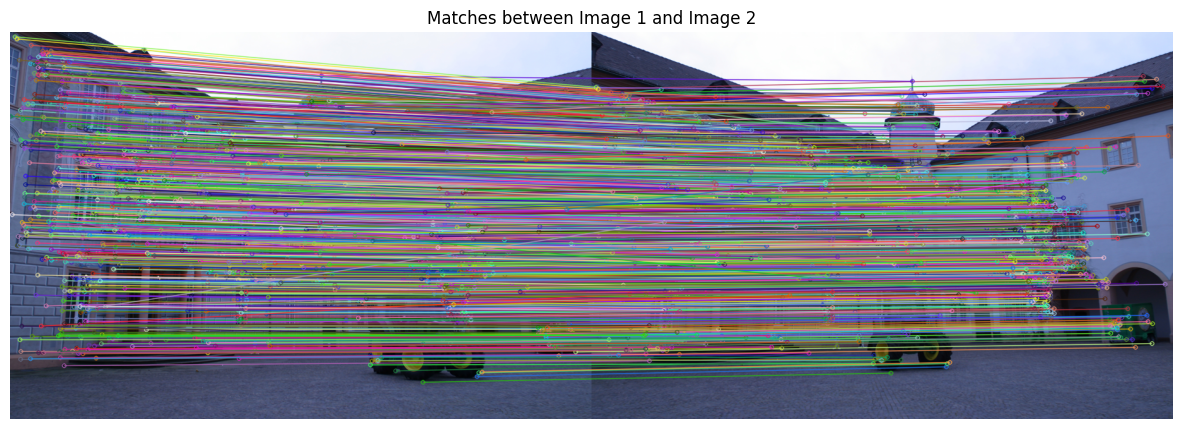

In [533]:
# Convert matches to cv2.DMatch format
cv_matches = []
for match in matches[(1, 2)]:
    query_idx = int(match[1])  
    train_idx = int(match[0]) 
    cv_matches.append(cv2.DMatch(_queryIdx=query_idx, _trainIdx=train_idx, _distance=0))

# Draw matches
img_matches = cv2.drawMatches(
    cv2.cvtColor(image1, cv2.COLOR_BGR2RGB), kp1, 
    cv2.cvtColor(image2, cv2.COLOR_BGR2RGB), kp2,
    cv_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.axis('off')
plt.title('Matches between Image 1 and Image 2')
plt.show()

As we can see from the obtained results, the number of matches obtained with COLMAP is very high (**1571**), and most of them appear to be geometrically consistent. However, from a visual inspection alone, it is not possible to determine with certainty if all correspondences are true inliers. 

However, by randomly visualizing small subsets of the matches, we were able to identify some outliers (up to 6) that are not easily noticeable when all correspondences are displayed at once. This confirms that a purely visual inspection is not sufficient to reliably separate correct matches from incorrect ones when there are many matches obtained.


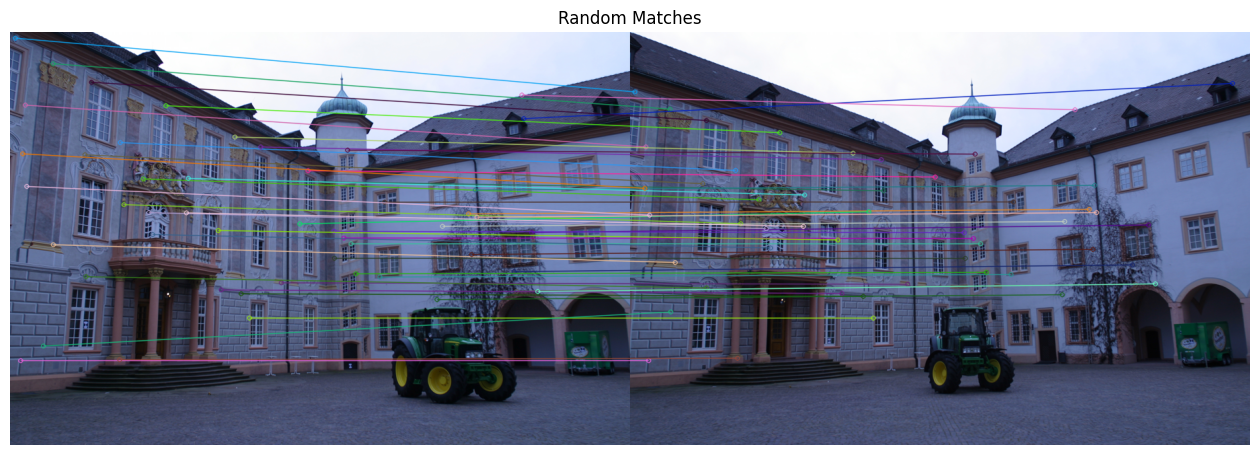

In [473]:
def draw_match_sample(img1, kp1, img2, kp2, matches, n=10, title=""):
    if len(matches) > n:
        matches = random.sample(matches, n)
    vis = cv2.drawMatches(
        cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), kp1,
        cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(16, 10))
    plt.imshow(vis)
    plt.axis("off")
    plt.title(title)
    plt.show()

draw_match_sample(image1, kp1, image2, kp2, cv_matches, n=50, title="Random Matches")


If we compare these results with those obtained in Lab 3, we can observe some differences.

In Lab 3, we obtained **1290** raw matches before applying RANSAC, which were reduced to **650** inliers after geometric verification. This clearly shows that a significant number of outliers were present and that applying RANSAC was essential to remove incorrect correspondences. The effect of this filtering step can be clearly observed in **Figure 7**.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center; width: 45%;">
    <img src="figures/lab3_matches_before_ransac.png" style="width: 100%;">
    <p><b>(a)</b> Matches before RANSAC (1290).</p>
  </div>
  <div style="text-align: center; width: 45%;">
    <img src="figures/lab3_matches_after_ransac.png" style="width: 100%;">
    <p><b>(b)</b> Matches after RANSAC (650).</p>
  </div>
</div>

<p align="center">
  <b>Figure 7:</b> Comparison of Lab 3 results before and after applying RANSAC. 
  A large number of incorrect correspondences are removed after geometric verification, 
  leading to a more consistent set of matches.
</p>

ORB is a simpler and faster descriptor, and it generally detects fewer keypoints compared to SIFT. As a result, the total number of matches is lower. However, after RANSAC, the remaining correspondences appear to be more geometrically consistent (*although, as mentioned before, a purely visual inspection is not sufficient to guarantee that all matches are true inliers; by randomly sampling small subsets, we were only able to identify at most **two** remaining outliers*). 

Overall, this comparison highlights an important trade-off between both approaches. Simpler methods such as ORB may produce fewer correspondences, but these can be highly consistent after geometric filtering. On the other hand, more advanced pipelines tend to generate a much denser set of matches, which is beneficial for tasks such as 3D reconstruction, even if some outliers are introduced.

In the case of COLMAP, the matches shown at this stage have **not yet passed any geometric verification**. These are raw descriptor-based matches stored in the database, and some outliers are still present. Geometric verification is applied later during the reconstruction process, where inconsistent matches are filtered out and only geometrically valid correspondences are used to create the 3D points.


## 2.6 Triangulate and visualize the 3D points from the keypoints extracted using Colmap on the two images used in lab 3, how it compares to the results from lab 3? (1.0) 

In this section, we triangulate 3D points from the two images used in Lab 3 (`0001_s.png` and `0002_s.png`) by reusing the triangulation pipeline developed in that lab, but replacing the keypoints and matches with those obtained from COLMAP.

We use the camera intrinsics and extrinsics estimated by COLMAP during the automatic reconstruction to build the projection matrices for both images. We will compare these intrinsics and camera poses with those estimated in Lab 3. Using the resulting projection matrices and the 2D–2D correspondences from the COLMAP matches, we triangulate the 3D points with the same DLT-based method used in Lab 3.

The resulting 3D point cloud is then visualized following the same style as in Lab 3.

#### <span style='color:Green'> - Use the triangulation from lab 3 to the get the 3D points and visualize them following the same style. </span>

In [543]:
# Parameters for COLMAP
img1_id, img2_id = 2, 1  # Shifted ids

# Get the images
img1 = images[img1_id]
img2 = images[img2_id]

# Get the camera (shared intrinsics)
camera = cameras[img1.camera_id]

In [544]:
# Comparison between Lab 3 camera matrices and COLMAP estimated intrinsic matrices

# Lab 3 K matrix
K_3 = np.array([[708.636, 0,  456.207],
              [0, 709.836,  302.043],
              [0, 0,  1]], dtype=float)
print("\nIntrinsic matrix K from Lab 3:")
print(K_3)

# COLMAP estimated K matrix
f, cx, cy, k = camera.params
K = np.array([[f, 0,  cx],
              [0, f,  cy],
              [0, 0,  1]], dtype=float)
print("\nIntrinsic matrix estimated by COLMAP::")
print(K)


Intrinsic matrix K from Lab 3:
[[708.636   0.    456.207]
 [  0.    709.836 302.043]
 [  0.      0.      1.   ]]

Intrinsic matrix estimated by COLMAP::
[[810.45886377   0.         461.        ]
 [  0.         810.45886377 307.        ]
 [  0.           0.           1.        ]]


In Lab 3 we obtained $f_x = 708.64$ and $f_y = 709.84$, while COLMAP estimates a single focal length $f_x = f_y = 810.46$. This corresponds to an increase of approximately **+101.8 px** with respect to $f_x$ and **+100.6 px** with respect to $f_y$, which is around **14% larger**.

For the principal point, Lab 3 gives $(c_x, c_y) = (456.21, 302.04)$, whereas COLMAP estimates $(c_x, c_y) = (461.00, 307.00)$ . This represents a shift of about **(+4.8 px, +5.0 px)**, which is relatively small compared to the image resolution.

Overall, COLMAP recovers a principal point very close to the one estimated in Lab 3, and a focal length of the same order of magnitude but a bit larger. This difference is expected given the simplified camera model (`SIMPLE_RADIAL`) and the fact that the estimation is performed using only two images.

In [545]:
# Comparison between Lab 3 camera matrices and COLMAP estimated camera matrices

P1_3 = np.array([[708.636,   0.   , 456.207,   0.   ],
               [  0.   , 709.836, 302.043,   0.   ],
               [  0.   ,   0.   ,   1.   ,   0.   ]], dtype=float)

P2_3 = np.array([[ 6.224e+02,  3.430e+01,  5.672e+02, -5.331e+02],
                [-8.658e+01,  7.075e+02,  2.951e+02,  1.645e+02],      
                [-1.655e-01, -4.747e-03,  9.862e-01,  3.030e-01]], dtype=float)

print("\nProjection matrices from Lab 3:")
print("P1: \n", P1_3)

print("P2: \n", P2_3)

# Projection matrices
def P_from_image(img, K):
    R = img.qvec2rotmat()
    t = img.tvec.reshape(3, 1)
    return K @ np.hstack([R, t])

P1 = P_from_image(img1, K)
P2 = P_from_image(img2, K)

print("\nProjection matrices from COLMAP:")
print("P1: \n", P1)
print("P2: \n", P2)


Projection matrices from Lab 3:
P1: 
 [[708.636   0.    456.207   0.   ]
 [  0.    709.836 302.043   0.   ]
 [  0.      0.      1.      0.   ]]
P2: 
 [[ 6.224e+02  3.430e+01  5.672e+02 -5.331e+02]
 [-8.658e+01  7.075e+02  2.951e+02  1.645e+02]
 [-1.655e-01 -4.747e-03  9.862e-01  3.030e-01]]

Projection matrices from COLMAP:
P1: 
 [[ 8.72253180e+02 -4.59305188e+01  3.26235111e+02  3.23078717e+03]
 [ 8.98967210e+01  8.05507378e+02  3.06869701e+02 -6.75553762e+02]
 [ 1.58598364e-01 -1.26853857e-02  9.87261688e-01 -1.40919265e+00]]
P2: 
 [[ 8.10458864e+02  0.00000000e+00  4.61000000e+02 -2.63970359e+03]
 [ 0.00000000e+00  8.10458864e+02  3.07000000e+02  1.08134722e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.15409656e+00]]


The numerical values clearly reflect the different choices of reference frame used in each case.

In Lab 3, the first camera matrix is exactly of the form $P_1 = K[I \mid 0]$, with zero translation and an identity rotation, confirming that the world coordinate system was explicitly fixed at the first camera. Consequently, the second camera matrix $P_2$ encodes a relative rotation and translation with respect to this canonical reference.

In contrast, the projection matrices estimated by COLMAP show non-zero translation components and non-identity rotations already in $P_1$. This indicates that COLMAP does not fix any camera to a canonical pose, but instead estimates all camera poses jointly in a global coordinate system. The large translation values observed in both $P_1$ and $P_2$ are therefore expected and simply reflect the arbitrary global reference frame chosen by COLMAP during optimization.

Despite these differences in absolute values, the rotation blocks of the matrices are well-formed and consistent, and the relative geometry between the two cameras is preserved. 


In [546]:
# Lab3 code for triangulation
def image_normalization_matrix(imsize):
    #Normalization matrix based on image size, maps image coordinates to [-1,1] range
    w, h = imsize
    return np.array([
        [2 / w,     0,     -1], #Scale x-coordinates to [-1, 1]
        [0,     2 / h,     -1], #Scale y-coordinates to [-1, 1]
        [0,         0,      1]
    ])

def hartley_normalization_matrix(x: np.ndarray) -> np.ndarray:
    #Normalization matrix based on Hartley normalization
    x = x.copy()
    x = x / x[2:3, :]                #Homogeneous to Euclidean coordinates
    pts = x[:2, :]                   #2D image coordinates

    c = np.mean(pts, axis=1)         #Centroid
    pts_c = pts - c[:, None]         #Translate points to centroid

    d = np.sqrt(np.sum(pts_c**2, axis=0)) #Euclidean distance to centroid
    mean_d = np.mean(d)                   #Mean distance from the centroid

    s = np.sqrt(2) / (mean_d + 1e-12) #Scale to get mean distance equals sqrt(2)

    T = np.array([
        [s, 0, -s * c[0]],
        [0, s, -s * c[1]],
        [0, 0, 1]
    ], dtype=float)         #Norm Matrix
    return T

def triangulate(x1, x2, P1, P2, imsize, norm='hartley') -> np.ndarray:
    #Triangulate 3D points from two views using the DLT method
    assert P1.shape == (3,4) == P2.shape
    assert x1.shape == x2.shape and x1.shape[0] == 3

    #Apply normalization to improve numerical stability
    if norm == 'image_size':
        T = image_normalization_matrix(imsize)
        P1n = T @ P1
        P2n = T @ P2
        x1n = T @ x1
        x2n = T @ x2
    elif norm == 'hartley':
        T1 = hartley_normalization_matrix(x1)
        T2 = hartley_normalization_matrix(x2)
        P1n = T1 @ P1
        P2n = T2 @ P2
        x1n = T1 @ x1
        x2n = T2 @ x2
    elif norm is None:
        P1n, P2n, x1n, x2n = P1, P2, x1, x2
    else:
        raise ValueError("norm must be None, 'image_size' or 'hartley'")

    def generate_Ai(x, P):
        #Construct the DLT constraint matrix for a single correspondenc
        x = x.copy()
        x = x / x[2] #Dehomogenize image point
        u, v = x[0], x[1]
        return np.vstack([
            v * P[2,:] - P[1,:],
            P[0,:] - u * P[2,:]
        ])

    N = x1.shape[1]
    X = np.zeros((4, N), dtype=float) #Homogeneous 3D points

    for i in range(N):
        #Build the full DLT system by stacking constraints from both views
        A = np.vstack([
            generate_Ai(x1n[:, i], P1n),
            generate_Ai(x2n[:, i], P2n)
        ])

        #Solve A X = 0 using SVD
        _, _, Vt = np.linalg.svd(A, full_matrices=False)
        Xi = Vt[-1, :] #Solution associated with smallest singular value

        #Normalize homogeneous coordinates
        if abs(Xi[3]) > 1e-12:
            Xi = Xi / Xi[3]

        X[:, i] = Xi

    return X

In [557]:
m = matches[(1, 2)]   # shape (M,2)

idx1 = m[:, 1]        # indices in image 1 keypoints
idx2 = m[:, 0]        # indices in image 2 keypoints

x1 = keypoints[img1_id][idx1].T  # shape (2,M)
x2 = keypoints[img2_id][idx2].T  # shape (2,M)

x1 = np.vstack([x1, np.ones((1, x1.shape[1]))]) # shape (3,M)
x2 = np.vstack([x2, np.ones((1, x2.shape[1]))]) # shape (3,M)

# Color
x_img = np.transpose(x1[:2]).astype(int)
rgb_txt = (image1[x_img[:,1], x_img[:,0]])/255

In [562]:
X_pred = triangulate(x1, x2, P1, P2, [camera.width, camera.height])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550, title="Triangulated 3D points (COLMAP)"))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()


When comparing the Lab 3 reconstruction with the Lab 4 result obtained using COLMAP camera parameters, ... <span style="color: red;">NO SE QUE DECIR EN LA COMPARACIÓN</span>

In **Figure 8**, the 3D point cloud obtained in Lab 3 is shown. This reconstruction was computed using the same triangulation pipeline but with camera matrices estimated within the lab framework and a reduced set of feature correspondences.

<div style="display: flex; justify-content: center;"> 
    <div style="text-align: center;"> 
    <img src="figures/triangulation_lab3.png" style="width: 45%;"> 
    </div> 
</div> 
<p align="center"><b>Figure 8:</b> Triangulated 3D point cloud obtained in Lab 3 using the estimated camera matrices and feature matches from Lab 3.</p>



## 2.7 Visualize the sparse reconstruction using the 2 images from lab 3, and the complete CASTLE dataset. Comment on the differences between techniques and number of images used. (1.0)
#### <span style='color:Green'> - Use the reconstruction from Colmap to the get the 3D points and visualize them following the same style, using two images and the complete dataset. </span>

# Using 2 images


In [ ]:
reconstruction_path = "./castle/sparse/0"
database_path = "./castle/database.db"

model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

model.create_window()
model.add_points(min_track_len=2) # Filter points seen in at least 2 images
model.add_cameras(scale=2)
model.show()

# Using 30 images


In [4]:
reconstruction_path = "./castle_P30/sparse/0"
database_path = "./castle_P30/database.db"

model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

model.create_window()
model.add_points() 
model.add_cameras(scale=0.25)
model.show()

**Figure 9** compares the sparse 3D reconstructions obtained.

<div style="display: flex; justify-content: center; gap: 20px;"> 
    <div style="text-align: center; width: 45%"> 
        <img src="figures/castle_2_images.png", style="width: 95%;"> 
        <p><b>(a)</b> Reconstruction with 2 images</p> 
    </div> 
    <div 
    style="text-align: center; width: 45%"> 
        <img src="figures/castle_30_images.png", style="width: 85%;"> 
        <p><b>(b)</b> Reconstruction with 30 images</p> 
    </div> 
</div> <p align="center"><b>Figure 9:</b> Comparison of sparse COLMAP reconstructions using two images and thirty images.</p>

With only 2 images, the reconstructed point cloud appears sparse and irregular, with a limited number of points forming an incomplete structure and several isolated outliers. The geometry lacks continuity and clear surface definition, reflecting the reduced amount of visual information available. Additionally, the camera poses are located far from the reconstructed points; in order to make the cameras visible in the visualization, the camera scale had to be increased (`scale = 2`), as they were otherwise too small to be observed.

With 30 images, the reconstructed point cloud is significantly denser and more continuous, forming well-defined surfaces and structures with far fewer isolated points. The scene geometry appears more complete and coherent, and the presence of multiple camera poses distributed around the scene is clearly visible. In contrast to the 2-image case, the cameras are naturally well-scaled with respect to the point cloud and can be clearly observed without requiring manual scale adjustments.



# 3. Configure the reconstruction to improve the results. (1.0)

To improve the reconstruction quality in the _castle_ dataset we created a custom COLMAP script (`colmap_improved.sh`) with tuned parameters. Below we describe the key parameter changes we have set and explain how they help improve reconstruction quality.

The original castle reconstruction contained **missing parts and holes** in walls and the floor. These areas have relatively uniform appearance or very high-frequency texture patterns, which makes them challenging for feature-based reconstruction methods.

<img src="figures/castle_dense_base.png"/>

## COLMAP Pipeline Overview

COLMAP follows a sequential pipeline where each step builds upon the previous one. Understanding this pipeline helps us identify where improvements can be made:

1. **Feature Extraction** → Detect and describe keypoints in each image
2. **Feature Matching** → Find correspondences between image pairs
3. **Sparse Reconstruction** → Estimate camera poses and triangulate a sparse 3D point cloud
4. **Dense Stereo** → Compute dense depth maps for each image
5. **Depth Fusion** → Merge depth maps into a consistent dense point cloud
6. **Meshing** → Convert the point cloud into a triangular mesh

## Parameter Analysis by Pipeline Stage

### 1. Feature Extraction

We hypothesized that the problematic low-texture areas might not have enough keypoints detected, leading to sparse or missing matches. SIFT (Scale-Invariant Feature Transform) detects keypoints by finding local extrema in a scale-space pyramid built from Difference-of-Gaussians (DoG) images.

To increase keypoint detection in subtle texture regions, we modified:

- **`num_octaves`: 4 → 5** — SIFT builds a pyramid of progressively downsampled images (octaves). Adding one more octave allows detection of **larger-scale features** that might be present in uniform areas where fine details are absent.

- **`octave_resolution`: 3 → 4** — Within each octave, SIFT computes multiple DoG images at different scales. Increasing the resolution provides **finer scale sampling**, which can detect features at intermediate scales that would otherwise be missed.

- **`peak_threshold`: 0.0067 → 0.006** — This threshold filters out keypoints with low contrast in the DoG response. Lowering it makes SIFT **more sensitive to subtle features**, accepting keypoints with weaker gradients that are common in low-texture regions.

### 2. Feature Matching

Even with more keypoints, low-texture areas often produce similar-looking descriptors that are hard to match uniquely. We enabled:

- **`guided_matching`: 0 → 1** — After an initial set of matches is found, guided matching uses the estimated epipolar geometry to **search for additional correspondences** along epipolar lines. This is particularly useful for low-texture regions where descriptor-only matching might miss valid correspondences due to ambiguous descriptors.

### 3. Sparse Reconstruction (Mapper)

The mapper estimates camera poses through incremental Structure-from-Motion. We adjusted:

- **`init_min_num_inliers`: 100 → 50** — The initial image pair needs sufficient inlier matches to bootstrap the reconstruction. Lowering this threshold allows initialization even when the best image pair has **fewer high-quality matches**, which can happen in challenging scenes.

- **`ba_refine_principal_point`: 0 → 1** — By default, COLMAP assumes the principal point is at the image center. Enabling refinement allows bundle adjustment to **optimize the optical center position**, which can improve accuracy for cameras where the sensor is not perfectly centered.

### 4. Dense Stereo (PatchMatch)

This is arguably the most critical stage for our problem. PatchMatch Stereo computes dense depth by comparing image patches across views. For low-texture regions, the key insight is that **larger patches provide more context** for matching.

- **`window_radius`: 5 → 7** — This changes the patch size from **11×11 to 15×15 pixels**. In uniform areas, a small patch may look identical at many depths (the aperture problem). A larger patch is more likely to include some distinctive texture at the boundaries, enabling more reliable depth estimation. This is the **most important change** for addressing holes in walls and floors.

### 5. Depth Fusion

The fusion step merges per-image depth maps into a single consistent point cloud. Points are only kept if they are observed consistently across multiple views.

- **`min_num_pixels`: 5 → 3** — This threshold specifies the minimum number of images that must agree on a 3D point for it to be kept. Lowering it **retains more points**, including those in areas where fewer views provide reliable depth. This produces a denser point cloud at the cost of potentially more noise.

### 6. Poisson Meshing

Finally, Poisson surface reconstruction converts the oriented point cloud into a watertight mesh by solving a global optimization problem.

- **`depth`: 13 → 10** — This controls the octree depth used for reconstruction. A lower depth produces a **smoother mesh** with less fine geometric detail but fewer artifacts from noise. This helps close small remaining gaps and produces a cleaner final result.

## Summary

Our parameter tuning follows a logical chain of reasoning:

1. **More keypoints** in low-texture areas (SIFT parameters) → more potential matches
2. **Guided matching** → recover matches that descriptor-only matching misses
3. **Relaxed initialization** → successfully start reconstruction even with fewer matches
4. **Larger stereo patches** → reliable depth estimation despite uniform appearance
5. **Lower fusion threshold** → retain more 3D points to fill gaps
6. **Smoother meshing** → clean final surface with fewer artifacts

## Post-processing
Although the reconstruction quality was improved by adjusting the parameters described above, the result was still not perfect. For this reason, we applied a post-processing stage using MeshLab in order to further enhance the final reconstruction.

Our objective was to combine the improved **Poisson mesh** with the **Delaunay mesh** to obtain a more complete surface and to fill the missing regions present in the reconstruction. 

* First, isolated regions were removed from both meshes using the Remove Isolated Pieces (w.r.t. Diameter) filter, and remaining artifacts were manually deleted. 
* Then, the Delaunay mesh was smoothed using the `HC Laplacian Smoothing filter` to obtain a smoother and more regular surface.
* Afterwards, color information from the Poisson mesh was transferred to the Delaunay mesh using `Sampling > Vertex Attribute Transfer`.
* Finally, both meshes were merged into a single model using `Filters > Mesh Layer > Flatten Visible Layers`.

The resulting post-processed reconstruction is shown in **Figure 10**.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="figures/castle_post-processed_1.png" style="width: 85%;">
    <p><b>(a)</b> Front view of the post-processed reconstruction.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/castle_post-processed_2.png" style="width: 85%;">
    <p><b>(b)</b> Rear view of the post-processed reconstruction.</p>
  </div>
</div>

<p align="center">
  <b>Figure 10:</b> Post-processed reconstruction obtained by combining the Poisson and Delaunay meshes after artifact removal, smoothing, color transfer, and mesh merging.
</p>


You can download the meshes from here:

* [Castle raw mesh](https://drive.google.com/file/d/1ej_pujs_XPFn0cvNjimg0Zy8eb8i7NTJ/view?usp=sharing)

* [Castle configured mesh](https://drive.google.com/file/d/1pBHUrYt-E11S7HTl4ITvFyz_J9Gdu-sr/view?usp=sharing)

* [Castle post-processed mesh](https://drive.google.com/file/d/19UBu3DBg2tbg9iIkrbqbvjosgrB8tcIx/view?usp=sharing)


# 4. Reconstruct a 3D mesh from images captured by you. (1.5)

Before taking our own photographs, we ensured that the camera focus and exposure were fixed. This was done to keep the camera parameters consistent across all images and to avoid changes in appearance that could negatively affect feature matching and reconstruction.

## UPF Campus

To reconstruct the UPF Campus, we captured the images using two different strategies in order to evaluate which one produced better reconstruction results.

* In the **first strategy**, we stood approximately at the center of the campus and took photos while rotating around ourselves, capturing images in all directions with good overlap.

* In the **second strategy**, we walked close to the campus walls and took photos of the opposite façades, moving around the campus in a roughly rectangular path.

**Figure 11** shows the *sparse* reconstructions obtained with each acquisition strategy.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="figures/approach_1.png" style="width: 73%;">
    <p><b>(a)</b> Sparse reconstruction using the first strategy.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/approach_2.png" style="width: 85%;">
    <p><b>(b)</b> Sparse reconstruction using the second strategy.</p>
  </div>
</div>

<p align="center">
  <b>Figure 11:</b> Sparse reconstructions of the UPF Campus obtained with two different image acquisition strategies.
</p>

We did not initially expect the first strategy to produce a spherical-like reconstruction. However, after analyzing the result of the second strategy, this behavior became more understandable.

Since the images in the first strategy were captured from a single location while rotating around the camera, the camera centers remain almost at the same position and only the viewing direction changes. As a result, the reconstructed points are distributed around the camera, forming a spherical structure.

In contrast, in the second strategy the camera is physically moved along the campus perimeter. This produces a clearer camera trajectory and leads to a reconstruction that better reflects the actual spatial layout of the scene.

Therefore, we selected the **second strategy** to perform the final reconstruction of the UPF Campus.

After selecting the second strategy, we computed a *dense* reconstruction of the UPF Campus using COLMAP’s dense pipeline. The dense point cloud was then converted into a surface using the **Poisson** surface reconstruction method, producing a raw mesh of the scene.

**Figure 12** shows the resulting raw dense reconstruction obtained with the Poisson mesher, visualized from two different viewpoints. This reconstruction captures the overall geometry of the campus but still contains noise and artifacts.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="figures/upf_raw_1.png" style="width: 85%;">
    <p><b>(a)</b> Raw dense reconstruction - view 1.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/upf_raw_2.png" style="width: 85%;">
    <p><b>(b)</b> Raw dense reconstruction - view 2.</p>
  </div>
</div>

<p align="center">
  <b>Figure 12:</b> Raw dense reconstruction of the UPF Campus generated using the Poisson surface reconstruction algorithm, visualized from two different viewpoints..
</p>

We also attempted to further configure and refine the reconstruction using the script described in Section 3. However, we did not observe significant improvements in the results, as the obtained raw reconstruction was already fairly complete and stable.

For this reason, instead of modifying the reconstruction parameters, we decided to apply simple **post-processing** techniques in Meshlab to improve the visual quality of the model. We generated two final mesh versions, both cleaned by **manually removing artifacts and isolated regions**.

The first mesh includes the **ground surface**, while the second one **removes the ground entirely**. The mesh without the ground allows for a clearer inspection of the reconstructed buildings and vertical structures, resulting in a cleaner and more visually readable model. In this version, the façades and main architectural elements are well reconstructed and easier to analyze.

Nevertheless, the mesh including the ground is also interesting to analyze. Although the ground contains several holes, these gaps are consistent with the image acquisition process, since objects such as vegetation, street furniture, or pedestrians occluded parts of the scene during image capture. Despite these occlusions, the reconstruction manages to recover portions of bushes, lampposts, and some campus furniture.

**Figure 13** shows a comparison between the two post-processed meshes, visualized from different viewpoints.

<div style="display: flex; justify-content: center; gap: 20px; flex-wrap: wrap;">
  <div style="text-align: center; width: 45%;">
    <img src="figures/upf_with_1.png" style="width: 85%;">
    <p><b>(a)</b> Post-processed mesh with ground – view 1.</p>
  </div>
  <div style="text-align: center; width: 45%;">
    <img src="figures/upf_with_2.png" style="width: 85%;">
    <p><b>(b)</b> Post-processed mesh with ground – view 2.</p>
  </div>
  <div style="text-align: center; width: 45%;">
    <img src="figures/upf_without_1.png" style="width: 85%;">
    <p><b>(c)</b> Post-processed mesh without ground – view 1.</p>
  </div>
  <div style="text-align: center; width: 45%;">
    <img src="figures/upf_without_2.png" style="width: 85%;">
    <p><b>(d)</b> Post-processed mesh without ground – view 2.</p>
  </div>
</div>

<p align="center">
  <b>Figure 13:</b> Comparison of the post-processed UPF Campus meshes.
  The top row shows the reconstruction including the ground, while the bottom row shows the mesh without the ground,
  allowing a clearer visualization of the reconstructed buildings and structures.
</p>

You can download the meshes from here:

* [UPF raw mesh](https://drive.google.com/file/d/1OFbEfYbgiofzWY8_JmnfisznnsQlpWDD/view?usp=sharing)

* [UPF post-processed mesh with ground](https://drive.google.com/file/d/1s87CK6g1ttbGBUc9jiVhnS9jkwTLCfZk/view?usp=sharing)

* [UPF post-processed mesh without ground](https://drive.google.com/file/d/1u4bjIr_1-OkfeCK_zTe6JBV16_2TvTI-/view?usp=sharing)

(*Note: We also attempted to further improve the reconstruction by following the post-processing steps described in Section 3, including the combination of the Poisson and Delaunay meshes to fill missing regions. However, in our case, the raw dense reconstruction obtained with the Poisson mesher was already fairly complete, and merging it with the Delaunay mesh did not result in a cleaner visualization. For this reason, we decided to keep only the Poisson-based mesh, as it provided a more visually clean and consistent reconstruction.*)

## Person

We attempted to reconstruct the upper body of a person without expecting a highly accurate result, as previous attempts with simpler objects such as bottles and notebooks did not lead to satisfactory 3D reconstructions. Despite these low expectations, the result was **surprisingly good**: although the reconstruction is not complete and the back part of the body is not properly recovered, the front region is clearly and consistently reconstructed, capturing the overall shape of the person to a convincing degree.

The reconstruction was generated using COLMAP’s Automatic Reconstruction pipeline, followed by surface generation with the Poisson mesher. After removing isolated regions using MeshLab, the resulting model shows that the front part of the person is reconstructed reasonably well, capturing the overall shape without applying any additional configuration or parameter tuning in COLMAP. However, the back part of the body is poorly reconstructed, with fragmented and noisy geometry, making it difficult to obtain a complete and consistent surface. See **Figure 14**.

<div style="display: flex; justify-content: center; gap: 20px;">
  <div style="text-align: center;">
    <img src="figures/person_1.png" style="width: 85%;">
    <p><b>(a)</b> 3D reconstruction of a person using COLMAP's Automatic Reconstruction - view 1.</p>
  </div>
  <div style="text-align: center;">
    <img src="figures/person_2.png" style="width: 85%;">
    <p><b>(b)</b> 3D reconstruction of a person using COLMAP's Automatic Reconstruction - view 2.</p>
  </div>
</div>

<p align="center">
  <b>Figure 14:</b> Poisson surface reconstruction of the upper body of a person obtained using COLMAP Automatic Reconstruction and MeshLab post-processing..
</p>

You can download the mesh from here: [Person mesh](https://drive.google.com/file/d/1lLWKX8ODKQzOToXyA7IhrVe_Uc2Z392R/view?usp=sharing)



# 5. Use Neuralangelo or Gaussian splatting to reconstruct a 3D mesh from images captured by you (Optional 2.0)